In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv("C://Users//reddy//Downloads//CPS_3.2_in_Substitute_Care_on_August_31_by_Placement_Type_with_Demographics_FY2014-2023_20240320.csv")  # Make sure to replace 'path_to_your_dataset.csv' with the actual path
print(df.head(5))

   Fiscal Year    County   Region  Gender    Race_Ethnicity  Age  \
0         2023  Anderson  4-Tyler  Female  African American    0   
1         2023  Anderson  4-Tyler  Female  African American    1   
2         2023  Anderson  4-Tyler  Female  African American    7   
3         2023  Anderson  4-Tyler  Female  African American    9   
4         2023  Anderson  4-Tyler  Female  African American   10   

  Type of Substitute Care                Placement Type Relative Placement  \
0             Foster Care  CPA Non-Relative Foster Home       Non-Relative   
1             Foster Care  CPA Non-Relative Foster Home       Non-Relative   
2             Foster Care     DFPS Relative Foster Home           Relative   
3             Foster Care  CPA Non-Relative Foster Home       Non-Relative   
4             Foster Care  CPA Non-Relative Foster Home       Non-Relative   

   Children in Subsitute Care on 31 August  
0                                        1  
1                               

In [4]:
bins = [0, 2, 5, 12, 17, 30]
labels = ['0-2', '3-5', '6-12','13-17','18 and above']

# Create a new column for the age groups
df['Age_Category'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True, include_lowest=True)
print(df['Age_Category'])

0                  0-2
1                  0-2
2                 6-12
3                 6-12
4                 6-12
              ...     
143337           13-17
143338           13-17
143339           13-17
143340           13-17
143341    18 and above
Name: Age_Category, Length: 143342, dtype: category
Categories (5, object): ['0-2' < '3-5' < '6-12' < '13-17' < '18 and above']


In [5]:
def map_placement_type(row):
    if row in ['CPA Non-Relative Foster Home']:
        return 'CPA_NonRelative'
    elif row in ['CPA Relative Foster Home']:
        return 'CPA_Relative'
    elif row in ['DFPS Non-Relative Foster Home']:
        return 'DFPS_NonRelative'
    elif row in ['CPA Adoptive Home','DFPS Adoptive Home']:
        return 'Adoptive_Home'
    elif row in ['DFPS Relative Foster Home']:
        return 'DFPS_Relative'
    elif row in ['Kinship Care']:
        return 'KinshipCare'
    elif row in ['Residential Treatment Center']:
        return 'RTC'
    else:
        return 'Other'
df['Placement_Type'] = df['Placement Type'].apply(map_placement_type)
df= df[df['Placement_Type'] != 'Other']
print(df['Placement_Type'].head(5))

0    CPA_NonRelative
1    CPA_NonRelative
2      DFPS_Relative
3    CPA_NonRelative
4    CPA_NonRelative
Name: Placement_Type, dtype: object


In [6]:
le = LabelEncoder()
df['E_Gender'] = le.fit_transform(df['Gender'])
df['E_Race_Ethnicity'] = le.fit_transform(df['Race_Ethnicity'])
df['E_County'] = le.fit_transform(df['County'])
#df['E_Placement_Type'] = le.fit_transform(df['Placement_Type'])
df['E_Age_Category'] =le.fit_transform(df['Age_Category'] )
#df['County']=le.fit_transform(df['County'])
df['E_Region']=le.fit_transform(df['Region'])
df['E_Type of Substitute Care'] =le.fit_transform(df['Type of Substitute Care'] )
df['E_Relative Placement']=le.fit_transform(df['Relative Placement'])


X = df[['E_Age_Category', 'E_Gender', 'E_Race_Ethnicity','E_County','E_Type of Substitute Care','E_Relative Placement']]  
y = df['Placement_Type']


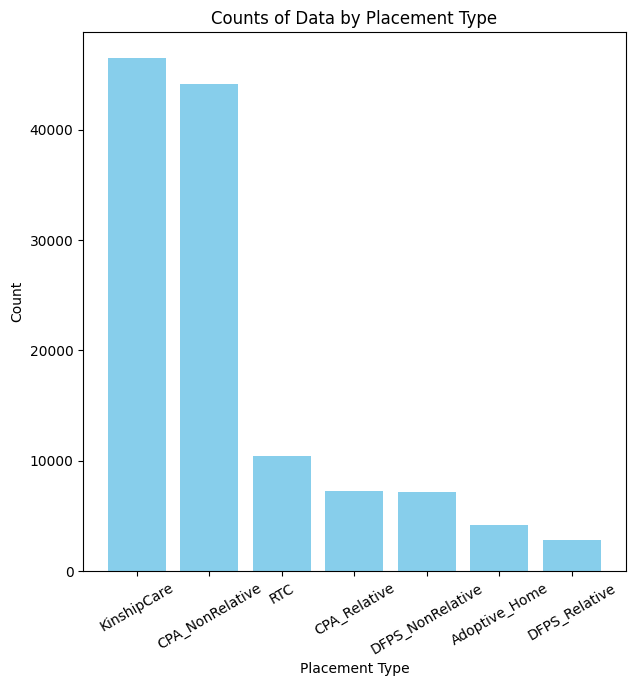

In [7]:
import matplotlib.pyplot as plt 
placement_counts = df['Placement_Type'].value_counts()
placement_counts_filtered = placement_counts
plt.figure(figsize=(7, 7))
plt.bar(placement_counts_filtered.index, placement_counts_filtered.values, color='skyblue')
plt.xlabel('Placement Type')
plt.ylabel('Count')
plt.title('Counts of Data by Placement Type')
plt.xticks(rotation=30)  # Rotate labels to improve readability
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [9]:
from collections import Counter

Class distribution after resampling: Counter({'DFPS_NonRelative': 37242, 'KinshipCare': 37242, 'RTC': 37242, 'CPA_NonRelative': 37242, 'Adoptive_Home': 37242, 'DFPS_Relative': 37242, 'CPA_Relative': 37242})


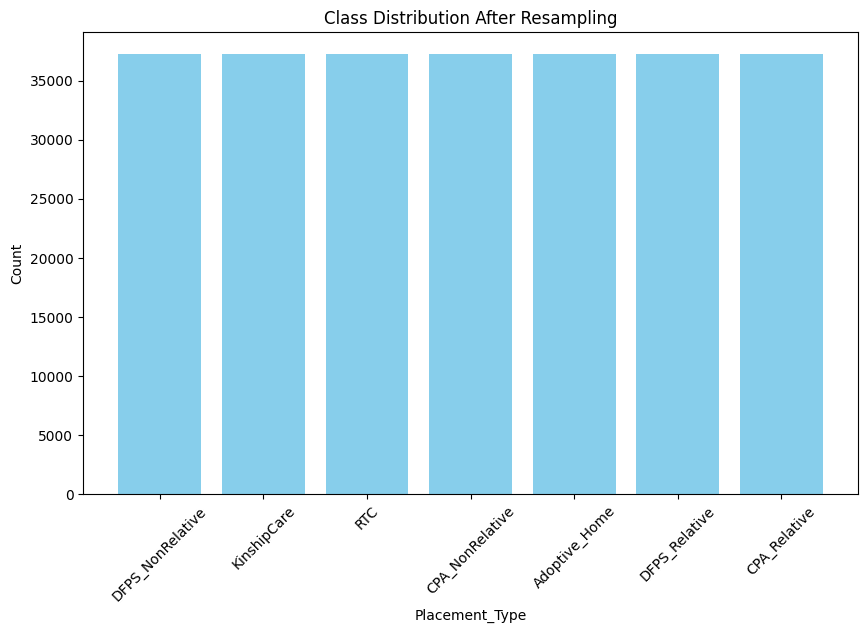

In [11]:
class_distribution = Counter(y_train_smote)
print("Class distribution after resampling:", class_distribution)
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Placement_Type')
plt.ylabel('Count')
plt.title('Class Distribution After Resampling')
plt.xticks(rotation=45)
plt.show()

In [12]:
rf = RandomForestClassifier(random_state=42, n_estimators=100,max_depth=None,          # Maximum depth of the trees
        min_samples_leaf=1,      # Minimum number of samples required at a leaf node
        min_samples_split=2, class_weight='balanced'    # Minimum number of samples required to split an internal node
       )
rf.fit(X_train_smote, y_train_smote)

y_pred = rf.predict(X_test)


In [13]:
from tabulate import tabulate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:\n{'-'*20}\n{accuracy:.2f}\n{'-'*20}")

# Generate the classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Drop the 'macro avg' and 'weighted avg' rows
report_df = report_df.drop(['accuracy'])

# Optionally, format the DataFrame for a more professional look
# For instance, rounding the numbers and excluding support might be desired
report_df = report_df.round(3)
report_df = report_df[['precision', 'recall', 'f1-score']]  # Exclude 'support' if you want
table = tabulate(report_df, headers='keys', tablefmt='pretty', showindex=True)
print(table)


Accuracy:
--------------------
0.73
--------------------
+------------------+-----------+--------+----------+
|                  | precision | recall | f1-score |
+------------------+-----------+--------+----------+
|  Adoptive_Home   |    1.0    |  1.0   |   1.0    |
| CPA_NonRelative  |   0.853   | 0.447  |  0.587   |
|   CPA_Relative   |   0.805   | 0.665  |  0.728   |
| DFPS_NonRelative |   0.246   | 0.603  |  0.349   |
|  DFPS_Relative   |   0.381   | 0.561  |  0.454   |
|   KinshipCare    |    1.0    |  1.0   |   1.0    |
|       RTC        |   0.389   | 0.784  |   0.52   |
|    macro avg     |   0.668   | 0.723  |  0.663   |
|   weighted avg   |   0.825   | 0.729  |  0.744   |
+------------------+-----------+--------+----------+


In [15]:
importances = rf.feature_importances_
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
print(features_df)

                     Feature  Importance
0       E_Relative Placement    0.349408
1  E_Type of Substitute Care    0.341675
2                   E_County    0.185696
3             E_Age_Category    0.100900
4           E_Race_Ethnicity    0.017781
5                   E_Gender    0.004540
